In [5]:
#imports
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

import matplotlib.pyplot as plt
import cv2


In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directory containing satellite images
IMG_DIR = Path("/content/drive/MyDrive/satellite-property-valuation/data/images")


Load Dataset

In [9]:
fusion_df = pd.read_csv("/content/drive/MyDrive/satellite-property-valuation/data/raw/train_data.csv")
fusion_df["id"] = fusion_df["id"].astype(int)


In [11]:
# Retain only properties with available satellite images
available_ids = sorted(
    int(float(p.stem)) for p in IMG_DIR.glob("*.png")
)

fusion_df = (
    fusion_df[fusion_df["id"].isin(available_ids)]
    .drop_duplicates("id")
    .reset_index(drop=True)
)

fusion_df.shape


(5488, 21)

Select Lowest & Highest Priced Samples

In [12]:
low_value_props  = fusion_df.nsmallest(3, "price")
high_value_props = fusion_df.nlargest(3, "price")

low_value_props[["id", "price"]], high_value_props[["id", "price"]]


(              id  price
 3596  3883800011  82000
 160   1322049150  85000
 5483  2422049104  85000,
               id    price
 530   9808700762  7062500
 3552  1924059029  4668000
 3089  3835500195  4489000)

Image Preprocessing

In [13]:
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


Load Pretrained CNN Backbone

In [14]:
cnn_backbone = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)

cnn_backbone.fc = nn.Identity()
cnn_backbone.to(device)
cnn_backbone.eval()

# Freeze CNN parameters
for param in cnn_backbone.parameters():
    param.requires_grad = False


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 54.6MB/s]


Grad-CAM Utility Class

In [15]:
class GradCAMHelper:
    def __init__(self, model, layer):
        self.model = model
        self.layer = layer
        self.gradients = None
        self.activations = None

        layer.register_forward_hook(self._capture_activations)
        layer.register_backward_hook(self._capture_gradients)

    def _capture_activations(self, module, inp, out):
        self.activations = out.detach()

    def _capture_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def compute(self, x):
        output = self.model(x)
        output.mean().backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max()

        return cam.squeeze().cpu().numpy()


Helper: Load Image by Property ID

In [21]:
def load_property_image(pid):
    p1 = IMG_DIR / f"{pid}.png"
    p2 = IMG_DIR / f"{pid}.0.png"

    img_path = p1 if p1.exists() else p2
    image = Image.open(img_path).convert("RGB")

    return image


Visualization Function

In [22]:
def render_gradcam(pid, price, label):
    img = load_property_image(pid)

    tensor_img = img_transform(img).unsqueeze(0).to(device)
    tensor_img.requires_grad = True

    cam_map = cam_engine.compute(tensor_img)

    cam_map = cv2.resize(cam_map, (224, 224))
    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_map),
        cv2.COLORMAP_JET
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    img_np = np.array(img.resize((224, 224)))
    overlay = (0.6 * img_np + 0.4 * heatmap).astype(np.uint8)

    plt.figure(figsize=(4, 4))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"{label}\n₹{price:,}")
    plt.show()


Initialize Grad-CAM

In [23]:
cam_engine = GradCAMHelper(
    model=cnn_backbone,
    layer=cnn_backbone.layer4
)


Visualize Low-Priced Properties

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


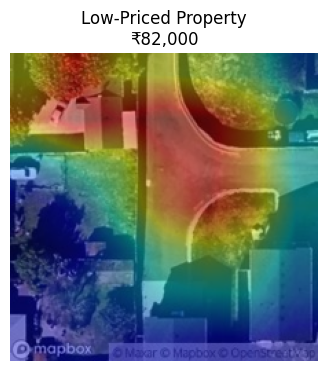

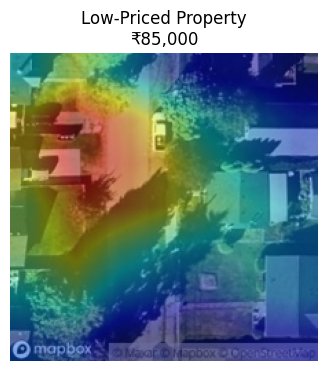

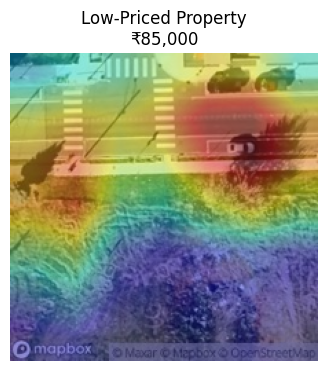

In [24]:
for _, row in low_value_props.iterrows():
    render_gradcam(
        pid=row["id"],
        price=row["price"],
        label="Low-Priced Property"
    )


Visualize High-Priced Properties

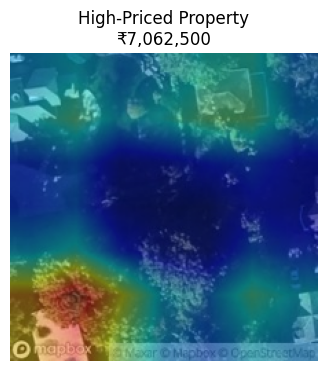

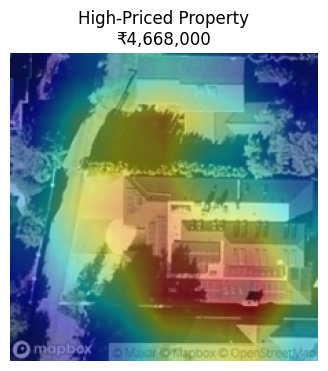

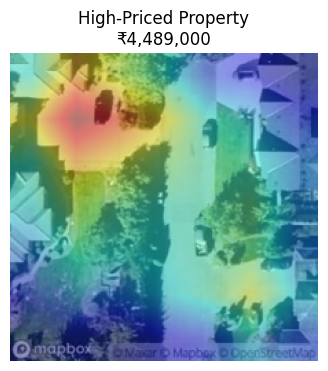

In [25]:
for _, row in high_value_props.iterrows():
    render_gradcam(
        pid=row["id"],
        price=row["price"],
        label="High-Priced Property"
    )
